# Continuous Meta-Learning without Tasks
Notebook  by: Swapnil Ahlawat

Paper link: https://arxiv.org/pdf/1912.08866.pdf

The paper tries to develop a generic wrapping algorithm that can enable any meta learning algorithm to perform well on unsegmented time-series data. It presents meta-learning via online changepoint analysis (MOCA), an approach that combines meta learning with differentiable Bayesian changepoint detection schemes to softly detect task switches and make predictions according to that.

For the prediction at every time step, MOCA maintains a belief (probability), b[r=t], over all possible run-lengths (Here run lengths mean number of past data points belonging to current task). It also maintains separate versions of the base meta learning algorithm’s posterior parameters for all possible run-lengths, n[t][r=x]. Then it uses the belief probability along with their probabilistic prediction for the label, p(yhat | x, n[t][r=x]), to calculate the final prediction probability, p(yhat | x[1:t], y[1:t-1]). The belief is updated after observing every datapoint. This way of maintaining belief acts as a **soft version of estimating the task switch points** in the unsegmented time-series.

Putting all the MOCA steps mathematically:
1. Predict p(yhat | x[1:t], y[1:t−1]): Summation of b[r]*p(yhat | x[t], n[t-1][r] over all run lengths
2. Observe label for current time step and calculate loss.
3. Update posterior parameters: Calculate n[t][r] for all run-lengths
4. Compute b[r | x[t], y[t]]: proportional to b[r]*p(y[t] | x[t], n[t-1][r])
5. Update belief: If r=0, b[r]= Hazard rate, else b[r]= (1- Hazard rate)*b[r-1 | x[t], y[t]]

*Hazard rate is probability that the current data point is the task switch point (Hyperparameter)*

During training, the losses are cumulated over the complete time series and then gradient update step is performed after that. There is no gradient update step in testing.

In the paper, there is also another step where you partial update belief based on only X, but this step relies on maintaining a generative model of the input variable, which is atypical for most regression models and is not
done for discriminative classification models. Hence, I have skipped that step in this notebook.

In this noteboook, I have done two experiments:
1. **Classification using CNP with MOCA**: I have implemented MOCA on top of CNP and compared its results with baseline, oracle and an ablated model.
2. **Time Series Forecasting using LSTM meta-learner with MOCA:** I have performed time-series forecasting using MOCA and LSTM meta-learner. Its result has been compared to a baseline model. A different way of calculating base meta-learning algorithm’s conditional posterior predictive, p(y[t] | x[t], n[t][r=x]),  in regression scenario has also been tried.

**Ablation performed:**

To see the role of belief probability in MOCA, I have compared the performance of general MOCA with that of a version of MOCA in which belief probability over all run-lengths is equal (uniform belief probability). This ablation is performed in experiment 1.

**Extensions performed:**
1. The paper demonstrated the utility of this approach only on regression and classification task. I have tried to use MOCA for a time-series forecasting task in experiment 2.
2. An easier way of calculating meta-learning algorithm’s conditional posterior predictive, p(y[t] | x[t], n[t][r=x]), in regression scenario has been implemented in experiment 2.


**To reproduce results:**
All the weights and datasets used are saved and given with this notebook. To reproduce the result, you can directly move on to result/test accuracy section of each model and get the results (without training the model). 

Running the complete notebook will overwrite these weights and datasets, so kindly keep a backup.

### Install packages
If you are running this on local environment and learn2learn installation fails, run the following command, restart the kernel and run the cell again:

>sudo apt install libjpeg8-dev zlib1g-dev

In [ ]:
! pip3 install torch torchvision torchaudio && pip install matplotlib && pip install scikit-learn && pip install learn2learn

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import learn2learn as l2l
import sklearn.datasets as skds
from sklearn.model_selection import train_test_split

In [ ]:
import random
import numpy as np
import matplotlib
import os
from scipy import randn, rand
import io
import base64
from IPython.display import HTML, clear_output

In [ ]:
dataset_folder='datasets/'
weight_folder= 'weights/'
result_folder= 'results/'

if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)

if not os.path.exists(weight_folder):
    os.mkdir(weight_folder)

if not os.path.exists(result_folder):
    os.mkdir(result_folder)

# Experiment 1: Classification using CNP with MOCA
CNP- https://arxiv.org/pdf/1807.01613.pdf

Implementation and performance comparison of CNP with MOCA on a 2-way classification task.

## Intuition behind using CNP
MOCA is required to maintain different versions of posterior parameters for various run-lengths which serves as distribution representation for these run-lengths. In the paper, for the classification task, they have assumed the data to follow Categorical-Gaussian generative model and used Dirichlet prior over the class probabilities and a Gaussian prior over the mean for each class and use its variables as posterior parameters.

Instead of following this complex probabilistic approach for classification, I have used CNP to learn these posterior parameters and perform classification. For each run-length, the adapt step in CNP encodes all the data points of that run-length into a vector that act as a posterior parameter in MOCA(representation of distribution for this run-length). As the encoding weights would also be updated in every training step, CNP would keep on learning a better way to encode the distribution. 

The model was able to achieve 83% test accuracy within 2000 epochs.

## Unsegmented Time-series Euclidean Dataset Generation
The code for generating euclidean dataset has been taken from Meta Learning course notebooks. It has been modified to get unsegmented time-series dataset.

A 20-way 20-dimensional euclidean dataset has been used for generating dataset.

In [ ]:
class MyDS(Dataset):
    def __init__(self, X,y):
        self.samples = torch.Tensor(X)
        self.labels = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return (self.samples[idx],self.labels[idx])

In [ ]:
def euclideanDataset(n_samples=1000,n_classes=2,class_sep=2.0,n_features=5,batch_size=1):
    X,y = skds.make_classification(n_samples=n_samples,n_classes=n_classes,
                                   class_sep=class_sep,n_features=n_features, 
                                 n_informative=n_features,n_redundant=0,
                                 n_repeated=0,n_clusters_per_class=1)
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    ds = MyDS(X_train,y_train)
    ds_hold = MyDS(X_test,y_test)
    dsloader = torch.utils.data.DataLoader(dataset=ds,batch_size=batch_size,shuffle=True)
    return ds,ds_hold,dsloader

In [ ]:
#20-dimensional Euclidean dataset with 20 class labels
meta_train_ds, meta_test_ds, _ = euclideanDataset(n_samples=20000,n_features=20,n_classes=20,batch_size=32)

In [ ]:
class KShotLoader():
    def __init__(self,myds,num_tasks=1000,shots=2,ways=2,classes=None):
        self.shots = shots
        self.ways = ways
        self.myMds = l2l.data.MetaDataset(myds)
        if classes == None:
            n_classes = len(set(myds.labels))
            classes = [i for i in range(n_classes)]
        self.my_tasks = l2l.data.TaskDataset(self.myMds, task_transforms=[
                                l2l.data.transforms.FilterLabels(self.myMds,classes),
                                l2l.data.transforms.NWays(self.myMds,ways),
                                l2l.data.transforms.KShots(self.myMds, shots),
                                l2l.data.transforms.LoadData(self.myMds),
                                l2l.data.transforms.RemapLabels(self.myMds),
                                l2l.data.transforms.ConsecutiveLabels(self.myMds)
                                ],num_tasks=num_tasks)
    def get_task(self):
        data,labels = self.my_tasks.sample()
        return data, labels

In [ ]:
ways= 2 #Number of ways

For getting training dataset, 1000 tasks with random number of shots between 2 to 10 are concatenated to generate unsegmented time-series training data.

In [ ]:
numTasks=1000
X_train=torch.empty(0)
y_train= torch.empty(0, dtype=torch.long)
oracle_tasks_train=[] #To get dataset with task switches known (for oracle model)
for i in range(numTasks):
    #Selecting Number of shots for this task
    shots= random.randint(2, 10)
    meta_train_kloader=KShotLoader(meta_train_ds,shots=shots,ways=ways,num_tasks=1000)
    X, y=meta_train_kloader.get_task()
    #Randomising Order of data points
    rp = torch.randperm(y.shape[0])
    X=X[rp]
    y=y[rp]
    #Concatenating the task to the unsegmented time series
    X_train= torch.cat([X_train, X], dim=0)
    y_train= torch.cat([y_train, y], dim=0)
    oracle_tasks_train.append((X, y))

Same method is used to get test dataset, but with only 100 tasks

In [ ]:
numTasks=100
X_test=torch.empty(0)
y_test= torch.empty(0, dtype=torch.long)
oracle_tasks_test=[] #To get dataset with task switches known (for oracle model)
for i in range(numTasks):
    #Selecting Number of shots for this task
    shots= random.randint(2, 10)
    meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways,num_tasks=1000)
    X,y=meta_test_kloader.get_task()
    #Randomising Order of data points
    rp = torch.randperm(y.shape[0])
    X=X[rp]
    y=y[rp]
    #Concatenating the task to the unsegmented time series
    X_test= torch.cat([X_test, X], dim=0)
    y_test= torch.cat([y_test, y], dim=0)
    oracle_tasks_test.append((X, y))

Saving Dataset

In [ ]:
if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)
torch.save((X_train, y_train), dataset_folder+'euclidean_train.pt')
torch.save((X_test, y_test), dataset_folder+'euclidean_test.pt')
torch.save(oracle_tasks_train, dataset_folder+'euclidean_train_oracle.pt')
torch.save(oracle_tasks_test, dataset_folder+'euclidean_test_oracle.pt')

## Models

In [ ]:
# Load Dataset
X_train, y_train= torch.load(dataset_folder + 'euclidean_train.pt')
X_test, y_test= torch.load(dataset_folder +'euclidean_test.pt')

In [ ]:
# Load Oracle data
data_train= torch.load(dataset_folder+'euclidean_train_oracle.pt')
data_test= torch.load(dataset_folder+'euclidean_train_oracle.pt')

MLP class (Taken from Meta Learning course notebooks)

In [ ]:
class MLP(nn.Module):
    def __init__(self,dims=[5,3,2],task='classification'):
        super(MLP,self).__init__()
        self.dims=dims
        self.n = len(self.dims)-1
        self.task=task
        self.layers=nn.ModuleList()
        for i in range(self.n-1):
            self.layers.append(nn.Linear(dims[i],dims[i+1]))
            self.layers.append(nn.ReLU())
        if task=='classification': 
            self.layers.append(nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(nn.LogSoftmax(dim=1))
        elif task=='regression': 
            self.layers.append(nn.Linear(dims[i+1],dims[i+2]))
            self.layers.append(nn.Linear(dims[i+2],1))
        else: self.layers.append(nn.Linear(dims[i+1],dims[i+2]))

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return(x)

CNP class (Taken from Meta Learning course notebooks and modified slightly)

In [ ]:
class CNP(nn.Module):
    def __init__(self,n_features=1,dims=[32,32],n_classes=2, optimizerReq=False, lr=1e-3):
        super(CNP,self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.dimL1 = [n_features]+dims
        self.dimL2=[n_features+n_classes*dims[-1]]+dims+[n_classes]
        self.mlp1 = MLP(dims=self.dimL1,task='embedding')
        self.mlp2 = MLP(dims=self.dimL2)
        if optimizerReq:
            self.optimizer=torch.optim.Adam(self.parameters(),lr=lr)
    
    def getEncodingSize(self):
        return self.dimL1[-1]*self.n_classes
    
    def adapt(self,X,y):
        R = self.mlp1(X)
        m = torch.eye(self.n_classes)[y].transpose(0,1)/self.n_classes
        r = (m@R).flatten().unsqueeze(0)
        return r
        
    def forward(self,X,r):
        rr = r.repeat(X.shape[0],1)
        p = self.mlp2(torch.cat((X,rr),dim=1))
        return p

### MOCA Class
This class has been implemented completely from scratch. It is wrapper class which requires a base model (CNP in this case).

Terminologies:
1. Hazard rate (hazard_rate): Probability that the current data point is the task switch point (Hyperparameter)
2. Run-length: Number of past data points belonging to current tasks.
2. Belief (logb): Probability distribution over all possible run-lengths. In essence, high belief for a particular run-length means that this is the most likely the run-length for current datapoint. (Softer version of task switches)

All the operations in this class are performed in log for improved numerical performance.

In [ ]:
class MOCA(nn.Module):
    def __init__(self, baseModel, hazard_rate, lossfn, lr=1e-4):
        super(MOCA,self).__init__()
        self.hazard_rate= hazard_rate
        self.baseModel= baseModel #Base meta-learning algorithm
        self.encodingSize= baseModel.getEncodingSize()
        self.lossfn= lossfn
        self.optimizer=torch.optim.Adam(self.parameters(),lr=lr)
    
    def forward(self, X, y):
        #Length of time-series data
        T= X.shape[0]
        #Initialising belief (b(r=0)=1)
        logb= torch.tensor([0])
        loss=0
        acc=0
        for t in range(T):
            yhat=[]
            #Calulcating p(yhat | x, history) for all run lengths
            for hist in range(t+1):
                if hist==0:
                    encoding= torch.randn((1,self.encodingSize))
                else:
                    #Using CNP adaptation step to caclulate posterior parameters (history)
                    encoding= self.baseModel.adapt(X[t-hist:t], y[t-hist:t])
                #Storing log( b(r=len(history)) * p(yhat | x, history))
                yhat.append(self.baseModel(X[None,t], encoding) + logb[hist])
            yhat= torch.stack(yhat)
            #Summing over b(r=len(history)) * p(yhat | x, history) to get prediction probability p(yhat | x[1:t], y[1:t-1]) (Marginalisation)
            ypred= torch.logsumexp(yhat, dim=0)
            _, predicted = torch.max(ypred, 1)
            if(predicted==y[None, t]):
                acc+=1
            #Calculating loss
            loss+= self.lossfn(ypred, y[None, t])
            #Updating belief after observing the label
            #b(r=0)= hazard rate and b(r=t)= (1-hazard rate)*b(r=t-1) * p(yhat | x, history)
            logbhist= torch.log(torch.tensor(1-self.hazard_rate))+torch.log_softmax(yhat[:, 0, y[t]], dim=0)
            logb0= torch.log(torch.tensor([self.hazard_rate]))
            logb= torch.cat((logb0, logbhist))
        return loss, (acc/T)*100

#### Training

As the whole data series is very long and impractical to train on, we'll sample 
short random series from the whole series in every epoch and train on that.


Training parameters:
* Time-series length: 100-300 data points
* Epochs: 2000
* Learning rate: 1e-3 for first 1000 epochs and 1e-4 for next 1000 epochs
* Optimizer: Adam

The series lengths are kept considerably long (between 100-300 data points) to achieve good performance on low hazard rates, as short batch lengths artificially increase the hazard rate as a result of the assumption that each batch begins with a new task.

In [ ]:
epochs=2000
ways=2
lr=1e-3
hazard_rates= [0.01, 0.05, 0.1, 0.25, 0.5] #Model's performance testing for different hazard rates
lossfn = torch.nn.NLLLoss()

for hazard_rate in hazard_rates:
    #Initialise model
    net = CNP(n_features=20,n_classes=ways,dims=[32,64,32])
    model= MOCA(net, hazard_rate, lossfn, lr)

    for i in range(epochs):
        #Random starting point in series
        start= random.randint(0, X_train.shape[0]-100)
        #Random Length of series
        T= random.randint(100, min(300, X_train.shape[0]-start))
        #Getting the shorter time-series data
        X= X_train[start:start+T]
        y= y_train[start:start+T]
        loss, accuracy= model(X, y)
        print("Hazard rate: ", hazard_rate, "Epoch: ", i, "Data points:", T, "Accuracy:", accuracy)
        #Update step
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()

        #Change learning rate on epoch 1000
        if (i+1)==1000:
            for g in model.optimizer.param_groups:
                g['lr'] = 1e-4
    torch.save(model.state_dict(), weight_folder+'weights_MOCA_'+str(int(hazard_rate*100))+'.pt')

#### Test accuracies
During testing, time-series length can be as small as 50 data points. This has been done to also incorporate the performance of MOCA on shorter time-series.

In [ ]:
ways=2
lr=1e-3
hazard_rates= [0.01, 0.05, 0.1, 0.25, 0.5]
accuracies=[]
lossfn = torch.nn.NLLLoss()
T= [50, 100, 150, 200, 250, 300] # To get the performance on all run-lengths
for hazard_rate in hazard_rates:
    #Load model
    net = CNP(n_features=20,n_classes=ways,dims=[32,64,32])
    model= MOCA(net, hazard_rate, lossfn, lr)
    model.load_state_dict(torch.load(weight_folder + 'weights_MOCA_'+str(int(hazard_rate*100))+'.pt'))
    with torch.no_grad():
        accuracy=0
        start=0
        while start < y_test.shape[0]:
            for length in T:
                end= min(start+length, y_test.shape[0])
                if start==end:
                    break
                X= X_test[start:end]
                y= y_test[start:end]
                loss, acc= model(X, y)
                accuracy+= acc*(end-start)
                start=end
        accuracies.append(accuracy/y_test.shape[0])
        print("Hazard rate: ", hazard_rate, " Test accuracy: ", accuracy/y_test.shape[0])

### Ablation Performed: MOCA with Uniform Belief

To look at the importance of belief in MOCA, I've implemented another MOCA class, but in this version, the belief remains uniform for all run lengths (1/number of run-lengths).

In [ ]:
class MOCAUniformB(nn.Module):
    def __init__(self, baseModel, lossfn, lr=1e-4):
        super(MOCAUniformB,self).__init__()
        self.baseModel= baseModel
        self.encodingSize= baseModel.getEncodingSize()
        self.lossfn= lossfn
        self.optimizer=torch.optim.Adam(self.parameters(),lr=lr)
    
    def forward(self, X, y):
        #Length of time-series data
        T= X.shape[0]
        loss=0
        acc=0
        for t in range(T):
            yhat=[]
            #Calulcating p(yhat | x, history) for all run lengths
            for hist in range(t+1):
                if hist==0:
                    encoding= torch.randn((1,self.encodingSize))
                else:
                    encoding= self.baseModel.adapt(X[t-hist:t], y[t-hist:t])
                #Same as before, but here, b(r)= 1/time for all run lengths
                yhat.append(self.baseModel(X[None,t], encoding) + torch.log(torch.tensor(1/(t+1))))
            yhat= torch.stack(yhat)
            #Marginalisation step
            ypred= torch.logsumexp(yhat, dim=0)
            _, predicted = torch.max(ypred, 1)
            if(predicted==y[None, t]):
                acc+=1
            loss+= self.lossfn(ypred, y[None, t])
        return loss, (acc/T)*100

#### Training
Training parameters: Same as MOCA

In [ ]:
epochs=2000
ways=2
lr=1e-3
lossfn = torch.nn.NLLLoss()
net2 = CNP(n_features=20,n_classes=ways,dims=[32,64,32])
model2= MOCAUniformB(net2, lossfn, lr)

for i in range(epochs):
    #Random starting point in series
    start= random.randint(0, X_train.shape[0]-100)
    #Random Length of series
    T= random.randint(100, min(300, X_train.shape[0]-start))
    #Getting the shorter time-series data
    X= X_train[start:start+T]
    y= y_train[start:start+T]
    loss, accuracy= model2(X, y)
    print("Epoch: ", i, "Data points:", T, "Accuracy:", accuracy)
    model2.optimizer.zero_grad()
    loss.backward()
    model2.optimizer.step()
    #Change learning rate on epoch 1000
    if (i+1)==1000:
        for g in model2.optimizer.param_groups:
            g['lr'] = 1e-4
torch.save(model2.state_dict(), weight_folder + 'weights_MOCA_Uniform_B.pt')

#### Test accuracy

In [ ]:
ways=2
lr=1e-3
lossfn = torch.nn.NLLLoss()
net2 = CNP(n_features=20,n_classes=ways,dims=[32,64,32])
model2= MOCAUniformB(net2, lossfn, lr)
#Load saved model
model2.load_state_dict(torch.load(weight_folder + 'weights_MOCA_Uniform_B.pt'))
T= [50, 100, 150, 200, 250, 300]

with torch.no_grad():
    accuracy=0
    start=0
    while start < y_test.shape[0]:
        for length in T:
            end= min(start+length, y_test.shape[0])
            if start==end:
                break
            X= X_test[start:end]
            y= y_test[start:end]
            loss, acc= model2(X, y)
            accuracy+= acc*(end-start)
            start=end
    accuracy_UniformB = accuracy/y_test.shape[0]
    print("Test accuracy: ", accuracy_UniformB)

### Baseline model: Train on Everything
This implementation consists of ignoring task variation and treating the whole training timeseries as one task. Only CNP is used and it is adapted on all past data points.

In [ ]:
#Prediction function (Directly runs on CNP)
#Simple run over the time series where prediction is done by adapting over all the past data points
def predict(net, X, y, lossfn):
    T= X.shape[0]
    accuracy=0
    loss=0
    for t in range(T):
        if t==0:
            encoding= torch.randn((1,net.getEncodingSize()))
        else:
            encoding= net.adapt(X[:t], y[:t])
        yhat= net(X[None, t], encoding)
        _, predicted = torch.max(yhat, 1)
        if predicted==y[None, t]:
            accuracy+=1
        loss+= lossfn(yhat, y[None, t])
    return loss, (accuracy/T)*100

Training Parameters:
Same as MOCA except learning rate is 1e-3 for whole 2000 epochs

In [ ]:
ways=2
lr=1e-3
epochs=2000
lossfn = torch.nn.NLLLoss()
model3 = CNP(n_features=20,n_classes=ways,dims=[32,64,32], optimizerReq= True, lr=lr)
for i in range(epochs):
    start= random.randint(0, X_train.shape[0]-100)
    T= random.randint(100, min(300, X_train.shape[0]-start))
    X= X_train[start:start+T]
    y= y_train[start:start+T]
    loss, accuracy= predict(model3, X, y, lossfn)
    print("Epoch: ", i, "Data points:", T, "Accuracy:", accuracy)
    model3.optimizer.zero_grad()
    loss.backward()
    model3.optimizer.step()
torch.save(model3.state_dict(), weight_folder + 'weights_trainOnEverything.pt')

#### Test accuracy

In [ ]:
ways=2
lr=1e-3
lossfn = torch.nn.NLLLoss()
model3 = CNP(n_features=20,n_classes=ways,dims=[32,64,32], optimizerReq= True, lr=lr)
model3.load_state_dict(torch.load(weight_folder+'weights_trainOnEverything.pt'))
T= [50, 100, 150, 200, 250, 300]

with torch.no_grad():
    accuracy=0
    start=0
    while start < y_test.shape[0]:
        for length in T:
            end= min(start+length, y_test.shape[0])
            if start==end:
                break
            X= X_test[start:end]
            y= y_test[start:end]
            _, acc= predict(model3, X, y, lossfn)
            accuracy+= acc*(end-start)
            start=end
    accuracy_toe= accuracy/y_test.shape[0]
    print("Test Accuracy:", accuracy_toe)

### Oracle Model: CNP with Task Switches known
To get the maximum achievable accuracy, we train an Oracle model. Here, the task switches of the dataset are known beforehand and CNP is adapted on past data points of only that task.

Training Parameters: Same as MOCA but learning rate is 1e-3 for whole 2000 epochs

In [ ]:
ways=2
epochs=2000
lr=1e-3
lossfn = torch.nn.NLLLoss()
model4 = CNP(n_features=20,n_classes=ways,dims=[32,64,32], optimizerReq= True, lr=lr)
for i in range(epochs):
    numTasks= random.randint(8, 25)
    start= random.randint(0, len(data_train)-numTasks-1)
    loss=0
    accuracy=0
    for task in range(start, start+numTasks):
        X, y= data_train[task]
        ls, acc= predict(model4, X, y, lossfn)
        loss+=ls
        accuracy+=acc
    print("Epoch: ", i, "Accuracy:", accuracy/numTasks)
    model4.optimizer.zero_grad()
    loss.backward()
    model4.optimizer.step()
torch.save(model4.state_dict(), weight_folder+ 'weights_oracle.pt')

#### Test Accuracy

In [ ]:
ways=2
lr=1e-3
lossfn = torch.nn.NLLLoss()
model4 = CNP(n_features=20,n_classes=ways,dims=[32,64,32], optimizerReq= True, lr=lr)
model4.load_state_dict(torch.load(weight_folder + 'weights_oracle.pt'))
with torch.no_grad():
    accuracy=0
    totalDataPoints=0
    for task in range(len(data_test)):
        X, y= data_test[task]
        _, acc= predict(model4, X, y, lossfn)
        accuracy+= (acc*y.shape[0])
        totalDataPoints+=y.shape[0]
    accuracy_oracle= accuracy/totalDataPoints
    print("Test Accuracy:", accuracy_oracle)

## Experiment Results, Discussion and Conclusion

**Test Accuracies:**

MOCA Models: 
1. Hazard rate:  0.01 ------ 79.56%
2. Hazard rate:  0.05 ------ 80.17%
3. Hazard rate:  0.10 ------ 82.43%
4. Hazard rate:  0.25 ------ 83.04%
5. Hazard rate:  0.50 ------ 79.57%

MOCA with Uniform belief ---- 67.65%

Train on everything ----------- 55.56%

Oracle Model --------------------- 93.71%

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(hazard_rates, [accuracy_oracle for i in hazard_rates], label='Oracle Model (CNP with Task Switches known)')
plt.plot(hazard_rates, accuracies, label='MOCA', marker='o')
plt.plot(hazard_rates, [accuracy_UniformB for i in hazard_rates], label='MOCA with Uniform Belief')
plt.plot(hazard_rates, [accuracy_toe for i in hazard_rates], label='Baseline Model (Train on Everything)')
plt.legend()
plt.xlabel('Hazard rate')
plt.ylabel('Accuracy (%)')
plt.title('Accuraciey of various models')
plt.legend()
plt.show()

**Comparison of models:**
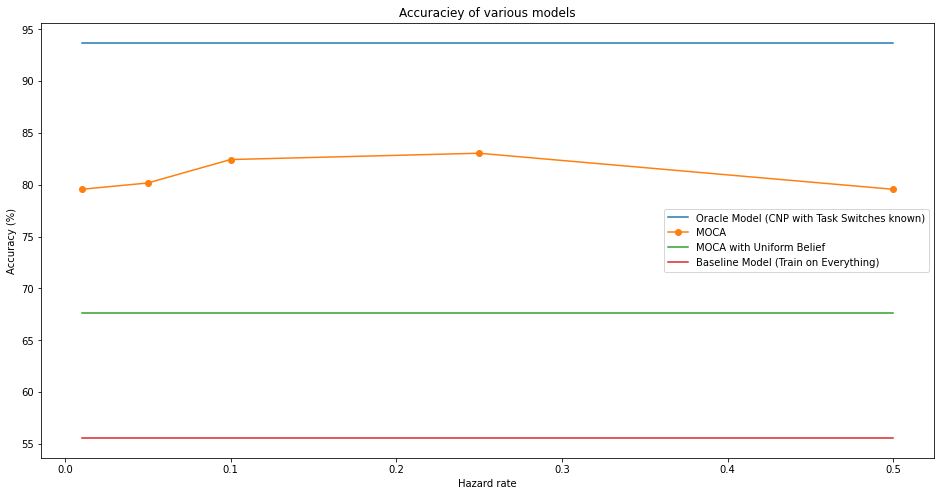


**Discussion and Conclusions:**
1. MOCA model with hazard rate 0.25 performs the best. The increased hazard rate is the result of the assumption that each batch begins with a new task.
2. The ablated model, MOCA with Uniform Belief, performs significantly better than the baseline Train on everything model. (12% improvement)
3. The accuracy of the ablated model, MOCA with Uniform Belief, is very less compared to the complete MOCA model. Hence, the belief probability plays a very significant role in MOCA. (15.5% improvement)
4. MOCA's accuracy is approximately 10% less than Oracle model's accuracy. The reason behind this is a very high task switch rate in the dataset (Task switches after every 12 data points on an average). MOCA is an approximation of our Oracle model and it'll generally waste at least 1 data point in getting to know that the task has switched. MOCA's performance will keep on getting closer to Oracle model's performance with the reduction of task switch rate.

# Experiment 2 (Extension of Paper): Time Series Forecasting using LSTM Meta-learner with MOCA

LSTM meta-learner: https://link.springer.com/chapter/10.1007/3-540-44668-0_13

Implementation of MOCA on top of LSTM meta-learner and comparing its performance on 2 bouncing balls dataset as a forecasting task.

**Extensions performed and their reason/intuition:**
1. The paper only discussed the performance of MOCA on regression and classification tasks. In this experiment, we'll be looking at MOCA's performance on a time-series forecasting task. From the previous experiment, we know that MOCA can detect task switches, but the motivation behind this experiment is that it can predict task switches.
2. MOCA requires base meta learning algorithm's conditional posterior predictive, p(y | x, n[t][r=x]) to update its belief probabilities. But this is not directly available in regression tasks. The paper uses a separate output from the decoder and do calculations on that to get this. Instead of doing that, I have attempted a much simpler way to calculate it by just using mean squared error.

## Bouncing Balls Generator
Because of the collisions against the wall/other balls, the bouncing balls dataset naturally has task switches. But the difference here is that, unlike our previous dataset where there were no relation between 2 tasks, these task switches can be predicted if the model learns to forecast the ball's trajectory and what action to take on collision.

Generator code taken from bb.py file uploaded on Meta Learning course page and modified to get ball coordinates instead of whole matrix.
This is done to get smaller dimensional dataset.

In [ ]:
#Taken from bb.py on Course website
def bounce_n(T=150, n=2, r=None, m=None, radius=0.5, size=10, gravity=0.05):
    if r==None: r=np.array([radius]*n)
    if m==None: m=np.array([1]*n)
    # r is to be rather small.
    X=np.zeros((T, n, 2), dtype='float')
    v = np.random.randn(n,2)
    v = v / norm(v)*.5
    good_config=False
    while not good_config:
        x = 2+np.random.rand(n,2)*8
        good_config=True
        for i in range(n):
            for z in range(2):
                if x[i][z]-r[i]<0:      good_config=False
                if x[i][z]+r[i]>size:     good_config=False
        # that's the main part.
        for i in range(n):
            for j in range(i):
                if norm(x[i]-x[j])<r[i]+r[j]:
                    good_config=False
                    
    eps = .5
    for t in range(T): # for how long do we show small simulation
        for i in range(n):
            X[t,i]=x[i]
        for mu in range(int(1/eps)):
            #Gravity
            for i in range(n):
                v[i][1]+=gravity
            for i in range(n):
                x[i]+=eps*v[i]
            for i in range(n):
                for z in range(2):
                    if x[i][z]-r[i]<0:  v[i][z]= abs(v[i][z]) # want positive
                    if x[i][z]+r[i]>size: v[i][z]=-abs(v[i][z]) # want negative
            for i in range(n):
                for j in range(i):
                    if norm(x[i]-x[j])<r[i]+r[j]:
                        # the bouncing off part:
                        w    = x[i]-x[j]
                        w    = w / norm(w)
                        v_i  = np.dot(w.transpose(),v[i])
                        v_j  = np.dot(w.transpose(),v[j])
                        new_v_i, new_v_j = new_speeds(m[i], m[j], v_i, v_j)
                        v[i]+= w*(new_v_i - v_i)
                        v[j]+= w*(new_v_j - v_j)
    return X

In [ ]:
#Helper functions
def ar(x,y,z): return z/2+np.arange(x,y,z,dtype='float')
def norm(x): return np.sqrt((x**2).sum())
def new_speeds(m1, m2, v1, v2):
    new_v2 = (2*m1*v1 + v2*(m2-m1))/(m1+m2)
    new_v1 = new_v2 + (v2 - v1)
    return new_v1, new_v2

In [ ]:
#Convert coordinate to matrix
def matricize(X,res,r=None, radius=0.5, size=10):
    T, n= np.shape(X)[0:2]
    if r==None: r=np.array([radius]*n)
    A=np.zeros((T,res,res), dtype='float')
    [I, J]=np.meshgrid(ar(0,1,1./res)*size, ar(0,1,1./res)*size)
    for t in range(T):
        for i in range(n):
            A[t]+= np.exp(-(  ((I-X[t,i,0])**2+(J-X[t,i,1])**2)/(r[i]**2))**4)
        A[t][A[t]>1]=1
    return A

In [ ]:
#Convert matrix to image
def show_sample(V, T):
    T   = len(V)
    res = int(np.sqrt(np.shape(V)[1]))
    for t in range(T):
        plt.imshow(V[t].reshape(res,res),cmap=matplotlib.cm.Greys_r) 
        # Save it
        fname = logdir+'/'+str(t)+'.png'
        plt.savefig(fname)      
        

Generating Dataset

In [ ]:
SIZE=10
n=2 #Number of balls
res=50
T=100 #Simulation length
N=250 #Number of simulations

In [ ]:
X_train=[]
for i in range(N):
    #Generate simulations with random ball radius and gravity
    RADIUS= random.uniform(0.1, 1)
    GRAVITY= random.uniform(0.01, 0.1)
    if i==0:
        visual_Radius_train= RADIUS
    X_train.append(bounce_n(T, n, radius=RADIUS, size=SIZE, gravity=GRAVITY))

In [ ]:
N_test=32
T_test=100
X_test=[]
for i in range(N_test):
    #Generate simulations with random ball radius and gravity
    RADIUS= random.uniform(0.1, 1)
    GRAVITY= random.uniform(0.01, 0.1)
    if i==0:
        visual_Radius= RADIUS
    X_test.append(bounce_n(T_test, n, radius=RADIUS, size=SIZE, gravity=GRAVITY))

### Visualing a sample

In [ ]:
V = matricize(X_train[0], res, radius=visual_Radius_train, size=SIZE)
dat_train= V.reshape(T, res**2)
logdir='train_sample'
if not os.path.exists(logdir):
    os.mkdir(logdir)

show_sample(dat_train, T)
os.system("ffmpeg -start_number 0 -i train_sample/%d.png -c:v libx264 -pix_fmt yuv420p -r 30 results/train_sample.mp4")

Run the cell below again if not able to play video

In [ ]:
video = io.open(result_folder + 'train_sample.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="640" height="480" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))



---


The data currently has shape (Batch, Sequence_Length, Number of Balls, Coordinates). 

To feed it into our model, we have to convert it into (Batch, Sequence_Length, Number of Balls * Coordinates) 

In [ ]:
X_train= np.array(X_train)
X_train= X_train.reshape((*X_train.shape[:-2], -1))

In [ ]:
X_test= np.array(X_test)
X_test= X_test.reshape((*X_test.shape[:-2], -1))

Generating Labels

In [ ]:
y_train= np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]-1):
        y_train[i][j]= X_train[i][j+1]- X_train[i][j]

In [ ]:
y_test= np.zeros(X_test.shape)
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]-1):
        y_test[i][j]= X_test[i][j+1]- X_test[i][j]

The coordinates are scaled down to 0-1 range, as that range is more amenable for training with standard network initialization.


In [ ]:
X_train/=SIZE

In [ ]:
X_test/=SIZE

Conversion to tensors and saving the dataset

In [ ]:
X_train= torch.from_numpy(X_train)
y_train= torch.from_numpy(y_train)

In [ ]:
X_test= torch.from_numpy(X_test)
y_test= torch.from_numpy(y_test)

In [ ]:
if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)
torch.save((X_train, y_train), dataset_folder+'bouncingBalls_train.pt')

In [ ]:
if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)
torch.save((X_test, y_test), dataset_folder+'bouncingBalls_test.pt')

## Models

LSTM Meta Learner Class

In this class, the LSTM input is the concatenation of the current encoded input z[t] = φ(x[t], w) (encoded using MLP) and the label from the past timestep y[t−1]. In this way, through the LSTM update process, the hidden state can process a sequence of input/label pairs and encode statistics of the posterior distribution in the hidden state.

The LSTM output and the encoded input are then concatenated and feeded into a decoding network (MLP) which outputs the label y[t]. By including z[t] as input to the decoder, we lessen the information that needs to be stored in the hidden state.

In [ ]:
class LSTMmeta(nn.Module):
    def __init__(self,input_features=1, encoding_dims=[32,32], lstm_hidden_dims=64, lstm_n_layers=1, decoding_dims=[32,32], optimizerReq=False, lr=1e-4):
        super(LSTMmeta,self).__init__()
        #Encoder
        dimEncoder = [input_features]+encoding_dims
        self.encoder = MLP(dims=dimEncoder,task='embedding')
        
        #LSTM
        self.output_features= input_features
        self.lstm_n_layers= lstm_n_layers
        self.lstm_hidden_dims= lstm_hidden_dims
        lstm_input_dims= encoding_dims[-1] + self.output_features
        self.lstm = nn.LSTM(lstm_input_dims, lstm_hidden_dims, lstm_n_layers, batch_first=True)
        
        #Decoder
        dimDecoder= [lstm_hidden_dims+encoding_dims[-1]]+ decoding_dims + [self.output_features]
        self.decoder = MLP(dims=dimDecoder,task='embedding')
        
        #Optimiser initialisation for baseline model
        if optimizerReq:
            self.optimizer=torch.optim.Adam(self.parameters(),lr=lr)

    def forward(self, X, y):
        #Encoding X[t]
        encoding= self.encoder(X)
        yzero= torch.zeros((X.shape[0], 1, self.output_features)) #All zeros for previous label of X[0] (required for concatenation for LSTM input)
        y= torch.cat((yzero, y), dim=1)
        input= torch.cat((encoding, y), dim=-1)

        #LSTM
        hidden_state = torch.randn((self.lstm_n_layers, X.shape[0], self.lstm_hidden_dims)).double()
        cell_state = torch.randn((self.lstm_n_layers, X.shape[0], self.lstm_hidden_dims)).double()
        hidden = (hidden_state, cell_state)
        out, hidden = self.lstm(input, hidden)

        #Decoding
        out = torch.cat((out[:, -1], encoding[:, -1]), dim=-1)
        yhat= self.decoder(out)
        return yhat      

### MOCA Class

The class has been implemented specifically for using MOCA in regression setting. 

For using MOCA with LSTM learner, yhat is calculated for all run-lengths by feeding them one by one to LSTM meta-learner but with different number of past data points. The final regression prediction yhat is the weighted average of yhat from all run lengths, weighted by the belief of that run-length.


**Calculating p(y[t] | x[t], n[t][r=x]) in regression setting:**

For easier and more intuitional calculation, p(y[t] | x[t], n[t][r=x]) is calculated by first getting the MSE loss individually on predictions from all run-lengths and then taking the inverse of it. As the predicted coordinates for a particular run-length digress from the label, MSE loss increases and its inverses decreases, leading to drop in belief probability for that run-length.

In [ ]:
class MOCA(nn.Module):
    def __init__(self, baseModel, hazard_rate, lossfn, lr=1e-4, SIZE=10):
        super().__init__()
        self.hazard_rate= hazard_rate
        self.baseModel= baseModel #Base meta-learning algorithm
        self.lossfn= lossfn
        self.SIZE=SIZE #Used to scale down label when forecasting
        self.optimizer=torch.optim.Adam(self.parameters(),lr=lr)
    
    def forward(self, X, y, T, forecast=False):
        # Initialising belief (b(r=0)=1)
        b= torch.ones((X.shape[0], 1))
        loss=0
        for t in range(T):
            yhat=[]
            weighted_yhat=[]
            #Repeating b to match number of input features (4 times for 2 bouncing balls case)
            bb = b[:, :, None].repeat(1, 1, X.shape[2])
            for hist in range(t+1):
                #Prediction from LSTM meta learner
                yhat0= self.baseModel(X[:, t-hist:t+1], y[:, t-hist:t])
                yhat.append(yhat0)
                #Storing b(r=len(history)) * p(yhat | x, history)
                weighted_yhat.append(yhat0*bb[:, hist])
            weighted_yhat= torch.stack(weighted_yhat)
            yhat= torch.stack(yhat)
            
            #Summing over b(r=len(history)) * p(yhat | x, history) to get prediction probability p(yhat | x[1:t], y[1:t-1]) (Marginalisation)
            ypred= torch.sum(weighted_yhat, dim=0)
            
            #Calculating loss (only when not forecasting)
            if not forecast:
                loss+= self.lossfn(ypred, y[:, t])
            
            # If forecasting and feeded data points are over, concatenate model's prediction to X and y
            if forecast and y.shape[1]<=t:
                y= torch.cat((y, ypred[:, None]), dim=1)
                X_next= X[:, t]+ (ypred/self.SIZE)
                X= torch.cat((X, X_next[:, None]), dim=1)

            #Updating belief
            pyhat= []
            for hist in range(t+1):
                # Storing b(r=t-1) * p(yhat | x, history) [p(yhat | x, history) calculated as inverse of loss]
                pyhat.append(b[:,hist]/torch.sum((y[:, t]-yhat[hist])**2, dim= 1))
            pyhat= torch.stack(pyhat)
            pyhat= torch.transpose(pyhat, 0, 1)
            #Normalisation step
            pyhatsum= torch.sum(pyhat, dim=1)
            for batch in range(X.shape[0]):
                pyhat[batch]= pyhat[batch].clone()/pyhatsum[batch].clone()
          
            #b(r=0)= hazard rate and b(r=t)= (1-hazard rate)*b(r=t-1) * p(yhat | x, history)
            b0= torch.ones((X.shape[0],1))*self.hazard_rate
            pyhat= pyhat*(1-self.hazard_rate)
            b= torch.cat((b0, pyhat), dim=1)
        
        if forecast: #If forward step for forecasting return predictions
            return X
        else:
            return loss #If forward step for training/testing, return loss

In [ ]:
#Loading stored dataset
X_train, y_train= torch.load(dataset_folder+'bouncingBalls_train.pt')

#### Training

Training parameters:

* Epochs: 750 (Model was overfitting post 750 epochs)
* Batch size: 8
* Learning rate: 1e-3 for first 500 epochs and 1e-4 for next 250 epochs
* Optimizer: Adam
* Encoding MLP dimensions: [4, 8, 16, 8]
* LSTM dimensions: 64-dimensional single layer
* Decoding MLP dimensions: [72 (64+8), 128, 4]
* Hazard rate: 0.01 

In [ ]:
#Initialising model
SIZE=10
lossfn= torch.nn.MSELoss()
net= LSTMmeta(4, [8, 16, 8], 64, 1, [128])
model= MOCA(net, 0.01, lossfn, 1e-3, SIZE).double()
epochs=750

In [ ]:
batch_size=8
for ep in range(epochs):
    #Selecting random batch of size 8 from all simulations
    rp = torch.randperm(X_train.shape[0])
    loss= model(X_train[rp[0:batch_size]], y_train[rp[0:batch_size]], X_train.shape[1]-1)
    print("Epoch ", ep, "Loss: ", loss.item())
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    #Reduce learning rate on epoch 500
    if (i+1)==500:
        for g in model.optimizer.param_groups:
            g['lr'] = 1e-4
torch.save(model.state_dict(), weight_folder + 'weights_MOCA_lstm.pt')

### Baseline Model: Condition on Everything
This implementation only uses LSTM meta-learner which runs on all available past data, as the LSTM can theoretically learn to only consider relevant data.

In [ ]:
#Function for calculating loss of LSTM meta-learner's prediction on complete simulation
def predict(net, X, y, T, lossfn):
    loss=0
    for t in range(T):
        yhat= net(X[:, :t+1], y[:,:t])
        loss+= lossfn(yhat, y[:, t])
    return loss

#### Training
Training parameters same as that of MOCA except epochs and learning rate.
* Epochs: 1000
* Learning rate: 1e-3 for first 500 epochs and 1e-4 for next 500 epochs

In [ ]:
lossfn= torch.nn.MSELoss()
model2= LSTMmeta(4, [8, 16, 8], 64, 1, [128], True, 1e-3).double()
epochs=1000
batch_size=8

for ep in range(epochs):
    rp = torch.randperm(X_train.shape[0])    
    loss= predict(model2, X_train[rp[0:batch_size]], y_train[rp[0:batch_size]], X_train.shape[1]-1, lossfn)
    print("Epoch ", ep, "Loss: ", loss.item())
    model2.optimizer.zero_grad()
    loss.backward()
    model2.optimizer.step()
    if (ep+1)==500:
        for g in model2.optimizer.param_groups:
            g['lr'] = 1e-4
torch.save(model2.state_dict(), weight_folder+'weights_lstm.pt')

## Time-series Forecasting & Comparison

### Loading test dataset and Feeding the first 10 frames into the model and forecasting

In [ ]:
X_pred, y_pred= torch.load(dataset_folder+'bouncingBalls_test.pt')
visual_Radius= 0.59 #Radius in 1st Simulation (for visualisation)

In [ ]:
T=100 # Final Simulation Length after forecasting
n=2 # No. of balls

Forecasting using MOCA + LSTM Meta-learner

In [ ]:
# Load model
SIZE=10
lossfn= torch.nn.MSELoss()
net= LSTMmeta(4, [8, 16, 8], 64, 1, [128])
model= MOCA(net, 0.01, lossfn, 1e-3, SIZE).double()
model.load_state_dict(torch.load(weight_folder+'weights_MOCA_lstm.pt'))

<All keys matched successfully>

In [ ]:
#Forecasting
with torch.no_grad():
    X_pred1= model(X_pred[:, 0:10], y_pred[:, 0:9], T-1, True)

Forecasting using Condition on everything baseline model

In [ ]:
SIZE=10
lossfn= torch.nn.MSELoss()
model2= LSTMmeta(4, [8, 16, 8], 64, 1, [128], True, 1e-3).double()
model2.load_state_dict(torch.load(weight_folder +'weights_lstm.pt'))

In [ ]:
with torch.no_grad():
    X_pred2=X_pred[:, 0:10]
    y_pred2=y_pred[:, 0:9]
    for t in range(T-10):
        y_next= model2(X_pred2, y_pred2)
        y_pred2= torch.cat((y_pred2, y_next[:, None]), dim=1)
        X_next= X_pred2[:, -1]+ y_next/SIZE
        X_pred2= torch.cat((X_pred2, X_next[:, None]), dim=1)

### Loss Comparison
We have the forecast from both the models and now we can calculate their MSE from the actual simulation.

In [ ]:
lossfn= torch.nn.MSELoss()
with torch.no_grad():
    loss_MOCA= lossfn(X_pred1[:, 10:], X_pred[:, 10:])
    loss_LSTM= lossfn(X_pred2[:, 10:], X_pred[:, 10:])

print("MOCA with LSTM Learner Loss: ", loss_MOCA.item())
print("Baseline Model Loss: ", loss_LSTM.item())

**Results:** (May vary a bit on every run)
1. MSE loss on testing on MOCA + LSTM meta-learner: 0.067
2. MSE loss on testing on baseline model: 0.082

### Visualing Forecast

In [ ]:
X_pred1= X_pred1[0].reshape((T, n, 2)).numpy()
X_pred2= X_pred2[0].reshape((T, n, 2)).numpy()

Convert coordinates to matrix

In [ ]:
res=50
V_pred1 = matricize(X_pred1, res, radius=visual_Radius/SIZE, size=1)
dat_pred1= V_pred1.reshape(T, res**2)

V_pred2 = matricize(X_pred2, res, radius=visual_Radius/SIZE, size=1)
dat_pred2= V_pred2.reshape(T, res**2)

Conver matrices to frames and then to video

In [ ]:
logdir='forecast_MOCA'
if not os.path.exists(logdir):
    os.mkdir(logdir)

show_sample(dat_pred1, T)
os.system("ffmpeg -start_number 0 -i forecast_MOCA/%d.png -c:v libx264 -pix_fmt yuv420p -r 30 results/MOCA_sample.mp4")

In [ ]:
logdir='forecast_LSTM'
if not os.path.exists(logdir):
    os.mkdir(logdir)

show_sample(dat_pred2, T)
os.system("ffmpeg -start_number 0 -i forecast_LSTM/%d.png -c:v libx264 -pix_fmt yuv420p -r 30 results/LSTM_sample.mp4")

MOCA forecast video

Run the cell below again if not able to play video

In [ ]:
video = io.open(result_folder+ 'MOCA_sample.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="640" height="480" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

Baseline forecast video

In [ ]:
video = io.open(result_folder +'LSTM_sample.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="640" height="480" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

## Discussion and Conclusion

1. MSE loss for MOCA with LSTM meta-learner is significantly less than baseline model on the time-series forecasting task. Even though it is only 0.015, the label y values stays in the approximate range of [-1.5, 1.5] and 0.015 loss difference means an average deviation of 0.122, which is significant. Hence, MOCA positively helps in predicting task switches and making right predictions.
2. The simple conditional posterior probability calculation using MSE loss reduced the complexity of the model while not negatively impacting the performance.
3. On visually comparing the forecasting of MOCA and the baseline model, we can see that even though both the able have not been able to accurately predict trajectories and collisions, MOCA is able to capture the effect of gravity and bouncing off the ground better than the baseline model. The prediction of MOCA seems more naturally plausible than that of the baseline model.



---


